In [7]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import statsmodels
from statsmodels.formula.api import ols

In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
os.chdir(config["PATH"]["project"])
project_path = config["PATH"]["project"]

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [4]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("covid_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

In [5]:
data_root = os.path.join(project_path, 'DATA/')

In [6]:
nyt = pd.read_csv( os.path.join(data_root, "us-counties.txt") )
nyt = nyt.astype( {"fips" : 'Int64', "deaths": 'Int64'})
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [7]:
nyt.shape

(1124916, 6)

## Daily cases

From cumulated cases an deaths, get the daily cases

In [8]:
nyt.sort_values([ "state", "fips","county", "date"] , inplace = True)
nyt.index = range(len(nyt))

Check whether there are NaN values in cases or deaths

In [9]:
nyt[nyt["cases"].isna()]

,date,county,state,fips,cases,deaths


In [10]:
nyt[nyt["deaths"].isna()]

,date,county,state,fips,cases,deaths
809610,2020-05-05,Adjuntas,Puerto Rico,72001,3,<NA>
809611,2020-05-06,Adjuntas,Puerto Rico,72001,3,<NA>
809612,2020-05-07,Adjuntas,Puerto Rico,72001,3,<NA>
809613,2020-05-08,Adjuntas,Puerto Rico,72001,3,<NA>
809614,2020-05-09,Adjuntas,Puerto Rico,72001,3,<NA>
...,...,...,...,...,...,...
834138,2021-03-11,Yauco,Puerto Rico,72153,1008,<NA>
834139,2021-03-12,Yauco,Puerto Rico,72153,1008,<NA>
834140,2021-03-13,Yauco,Puerto Rico,72153,1008,<NA>
834141,2021-03-14,Yauco,Puerto Rico,72153,1007,<NA>


In [11]:
nyt[nyt["deaths"].isna()]["state"].value_counts()

Puerto Rico    24533
Name: state, dtype: int64

In [12]:
len(nyt[nyt["state"] == "Puerto Rico"] )

24901

In [13]:
nyt[ (~nyt["deaths"].isna()) & (nyt["state"] == "Puerto Rico")]

,date,county,state,fips,cases,deaths
834143,2020-03-13,Unknown,Puerto Rico,<NA>,3,0
834144,2020-03-14,Unknown,Puerto Rico,<NA>,4,0
834145,2020-03-15,Unknown,Puerto Rico,<NA>,5,0
834146,2020-03-16,Unknown,Puerto Rico,<NA>,5,0
834147,2020-03-17,Unknown,Puerto Rico,<NA>,5,0
...,...,...,...,...,...,...
834506,2021-03-11,Unknown,Puerto Rico,<NA>,4463,2073
834507,2021-03-12,Unknown,Puerto Rico,<NA>,4468,2077
834508,2021-03-13,Unknown,Puerto Rico,<NA>,4476,2077
834509,2021-03-14,Unknown,Puerto Rico,<NA>,4478,2080


In Puerto Rico, cases are reported by county but deaths are global for the territory

In [14]:
group_nyt = nyt.groupby(["county", "state", "fips"], dropna = False)

In [15]:
nyt["daily_cases"] = group_nyt["cases"].diff().fillna( nyt["cases"])
nyt["daily_deaths"] = group_nyt["deaths"].diff().fillna( nyt["deaths"])

In [16]:
nyt[ nyt["daily_deaths"]< 0]["daily_deaths"].value_counts().sort_index()

-512       1
-299       1
-275       1
-234       1
-206       1
        ... 
-5        78
-4       137
-3       168
-2       496
-1      4041
Name: daily_deaths, Length: 79, dtype: Int64

In [17]:
nyt[ nyt["daily_deaths"] == -512]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
650041,2020-08-06,Nassau,New York,36059,43534,2194,52.0,-512


<AxesSubplot:xlabel='date'>

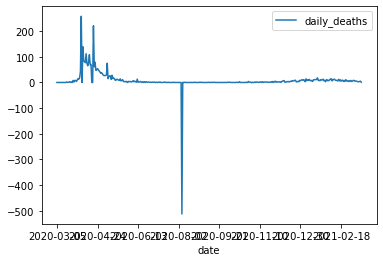

In [18]:
nyt[ nyt["fips"] == 36059 ].plot( x = "date", y = "daily_deaths")

In [19]:
deaths_anomalies = nyt[ nyt["daily_deaths"] < -100][["state", "fips", "county", "daily_deaths"]].sort_values("daily_deaths")
deaths_anomalies

,state,fips,county,daily_deaths
650041,New York,36059,Nassau,-512
661195,New York,<NA>,Unknown,-299
247341,Illinois,<NA>,Unknown,-275
414552,Louisiana,<NA>,Unknown,-234
836378,Rhode Island,<NA>,Unknown,-206
742274,Ohio,39153,Summit,-155
836354,Rhode Island,<NA>,Unknown,-148
659875,New York,36119,Westchester,-132
836651,Rhode Island,<NA>,Unknown,-124
836408,Rhode Island,<NA>,Unknown,-120


In [20]:
deaths_anomalies_2 = deaths_anomalies[ deaths_anomalies.columns[0:-1]].drop_duplicates()
deaths_anomalies_2

,state,fips,county
650041,New York,36059,Nassau
661195,New York,<NA>,Unknown
247341,Illinois,<NA>,Unknown
414552,Louisiana,<NA>,Unknown
836378,Rhode Island,<NA>,Unknown
742274,Ohio,39153,Summit
659875,New York,36119,Westchester


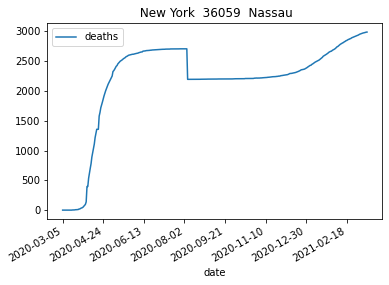

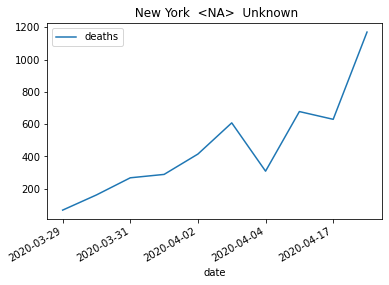

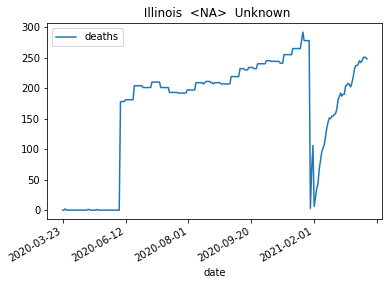

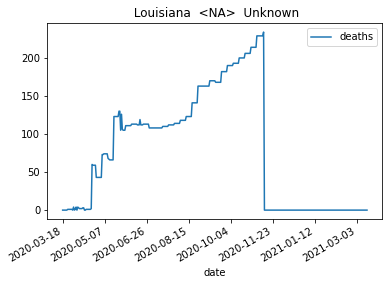

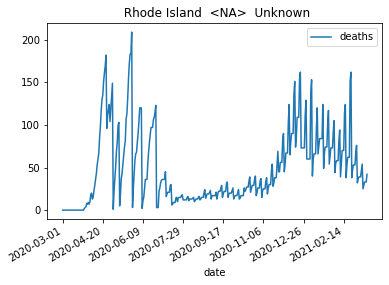

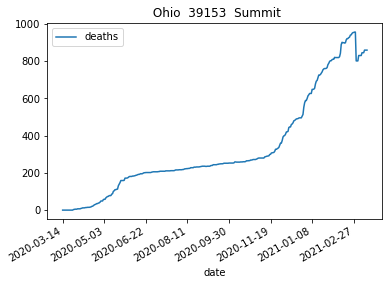

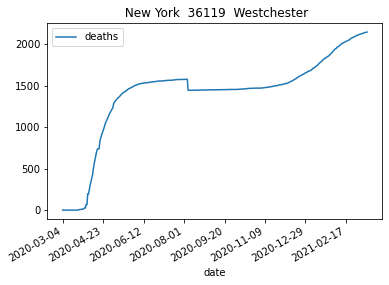

In [21]:
for i in range( len(deaths_anomalies_2)):
    df_merge = pd.merge( nyt, deaths_anomalies_2.iloc[i:i+1], on =["state", "fips", "county"])
    titel = deaths_anomalies_2.iloc[i:i+1].to_string(header = False, index = False)
    df_merge.plot( x = "date", y = "deaths", title = titel)
    plt.gcf().autofmt_xdate()

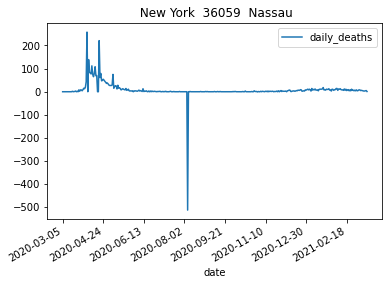

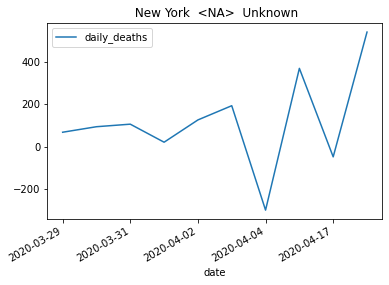

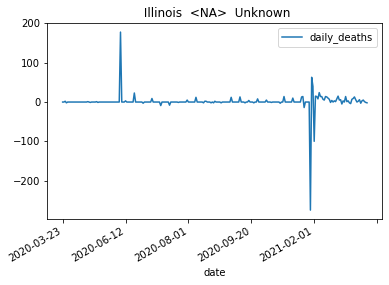

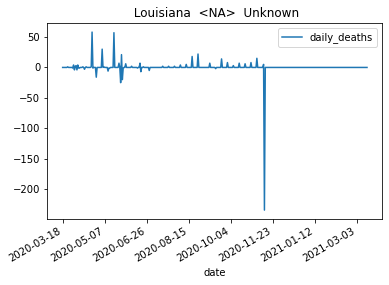

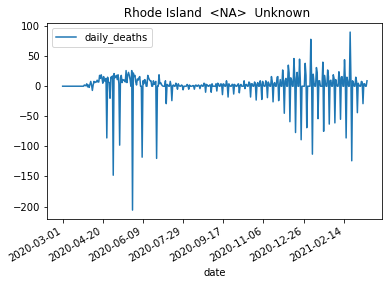

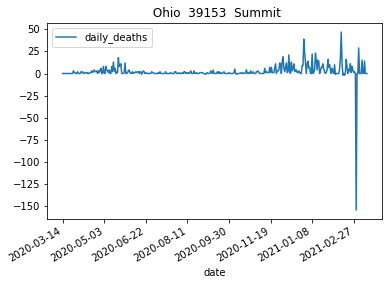

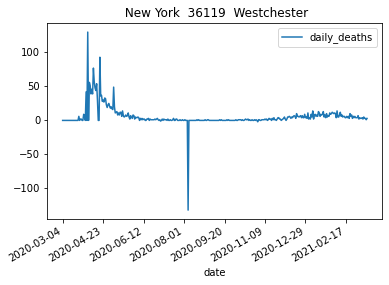

In [22]:
for i in range( len(deaths_anomalies_2)):
    df_merge = pd.merge( nyt, deaths_anomalies_2.iloc[i:i+1], on =["state", "fips", "county"])
    titel = deaths_anomalies_2.iloc[i:i+1].to_string(header = False, index = False)
    df_merge.plot( x = "date", y = "daily_deaths", title = titel)
    plt.gcf().autofmt_xdate()

In [23]:
rhodeisland = nyt[nyt["state"] == "Rhode Island"].groupby("date", dropna = False)[["cases", "deaths"]].sum()

In [24]:
rhodeisland["daily_deaths"] = rhodeisland["deaths"] - rhodeisland["deaths"].shift(fill_value = 0)
rhodeisland["daily_cases"] = rhodeisland["cases"] - rhodeisland["cases"].shift(fill_value = 0)

0
-130


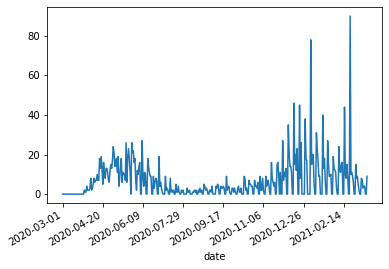

In [25]:
print(rhodeisland["daily_deaths"].min())
print(rhodeisland["daily_cases"].min())
ax = rhodeisland["daily_deaths"].plot()
plt.gcf().autofmt_xdate()

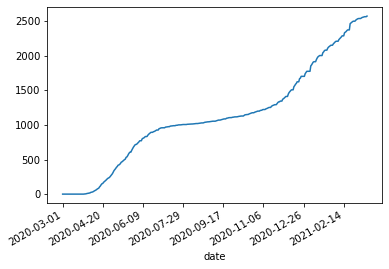

In [26]:
rhodeisland["deaths"].plot()
plt.gcf().autofmt_xdate()

In [27]:
pd.date_range("2020-12-01", "2020-12-31", freq = "D")

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [28]:
new_index = pd.to_datetime(rhodeisland.index)
rhodeisland.set_index( new_index, inplace = True)

In [29]:
rhodeisland["dayofweek"] = rhodeisland.index.dayofweek

In [30]:
rhodeisland.loc[ pd.date_range("2020-12-01", "2020-12-31", freq = "D"), [ "daily_cases", "dayofweek" ]]

,daily_cases,dayofweek
2020-12-01,1183,1
2020-12-02,1099,2
2020-12-03,1717,3
2020-12-04,1415,4
2020-12-05,0,5
2020-12-06,0,6
2020-12-07,3681,0
2020-12-08,1249,1
2020-12-09,1232,2
2020-12-10,948,3


In [31]:
rhodeisland.loc[ pd.date_range("2020-12-01", "2020-12-31", freq = "D"), [ "daily_deaths", "dayofweek" ]]

,daily_deaths,dayofweek
2020-12-01,7,1
2020-12-02,11,2
2020-12-03,9,3
2020-12-04,13,4
2020-12-05,0,5
2020-12-06,0,6
2020-12-07,35,0
2020-12-08,22,1
2020-12-09,14,2
2020-12-10,14,3


In [32]:
nyt[nyt["state"] == "Rhode Island"][ "county"].value_counts(dropna = False)

Unknown       380
Providence    356
Washington    356
Bristol       356
Kent          356
Newport       356
Name: county, dtype: int64

In [33]:
nyt[nyt["state"] == "Rhode Island"][ "fips"].value_counts(dropna = False)

NaN      380
44001    356
44003    356
44005    356
44007    356
44009    356
Name: fips, dtype: Int64

In [34]:
unknown_rhodeisland = nyt[ (nyt["state"] == "Rhode Island") & (nyt["county"] == "Unknown") ].copy()
unknown_rhodeisland["date"] = pd.to_datetime( unknown_rhodeisland["date"])
unknown_rhodeisland["dayofweek"] = unknown_rhodeisland["date"].dt.dayofweek

<AxesSubplot:xlabel='date'>

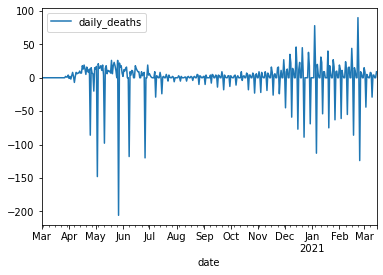

In [35]:
unknown_rhodeisland.plot( y = "daily_deaths", x = "date")

In [36]:
unknown_rhodeisland[ unknown_rhodeisland["date"].isin( pd.date_range("2021-01-01", "2021-01-31") )]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths,dayofweek
836597,2021-01-01,Unknown,Rhode Island,<NA>,9622,60,0.0,0,4
836598,2021-01-02,Unknown,Rhode Island,<NA>,9622,60,0.0,0,5
836599,2021-01-03,Unknown,Rhode Island,<NA>,9622,60,0.0,0,6
836600,2021-01-04,Unknown,Rhode Island,<NA>,14381,138,4759.0,78,0
836601,2021-01-05,Unknown,Rhode Island,<NA>,15525,153,1144.0,15,1
836602,2021-01-06,Unknown,Rhode Island,<NA>,10937,40,-4588.0,-113,2
836603,2021-01-07,Unknown,Rhode Island,<NA>,12065,60,1128.0,20,3
836604,2021-01-08,Unknown,Rhode Island,<NA>,13088,66,1023.0,6,4
836605,2021-01-09,Unknown,Rhode Island,<NA>,13088,66,0.0,0,5
836606,2021-01-10,Unknown,Rhode Island,<NA>,13088,66,0.0,0,6


In [37]:
unknown_rhodeisland.groupby("dayofweek").sum()

,fips,cases,deaths,daily_cases,daily_deaths
dayofweek,,,,,
0,0,303859,3029,43066.0,531
1,0,309459,3444,18990.0,457
2,0,225360,1971,-84099.0,-1473
3,0,242549,2345,17189.0,374
4,0,259437,2543,16888.0,198
5,0,260104,2570,667.0,27
6,0,260793,2498,689.0,-72


Negative daily values are mainly reported on wednesdays (and sometimes on sundays). Few deaths are reported on weekends. 

# Correlation between cases and deaths

In [38]:
nyc = nyt[ nyt["county"] == "New York City"]
nyc.set_index("date", inplace = True)
nyc

,county,state,fips,cases,deaths,daily_cases,daily_deaths
date,,,,,,,
2020-03-01,New York City,New York,<NA>,1,0,1.0,0
2020-03-02,New York City,New York,<NA>,1,0,0.0,0
2020-03-03,New York City,New York,<NA>,2,0,1.0,0
2020-03-04,New York City,New York,<NA>,2,0,0.0,0
2020-03-05,New York City,New York,<NA>,4,0,2.0,0
...,...,...,...,...,...,...,...
2021-03-11,New York City,New York,<NA>,766428,30068,3970.0,85
2021-03-12,New York City,New York,<NA>,770654,30116,4226.0,48
2021-03-13,New York City,New York,<NA>,773540,30174,2886.0,58


In [39]:
l = len(nyc)
l

380

In [41]:
def intercorrelation(serie1, serie2, lag_range):
    '''
    computing the intercorrelation btw serie1 and serie2, with shifts in lag range
    return a Series indexed by the lag
    '''
    return pd.Series( [serie1.astype("float64").corr(serie2.astype("float64").shift(lag)) for lag in lag_range], index = lag_range)

<AxesSubplot:>

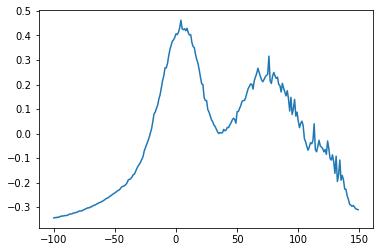

In [71]:
toto = intercorrelation(nyc["daily_deaths"], nyc["daily_cases"], range(-100,150))
toto.plot()

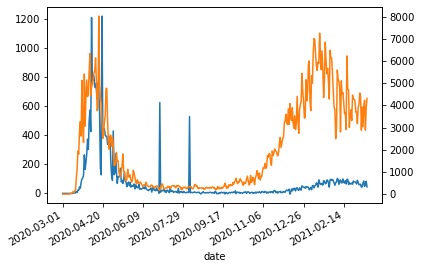

In [43]:
nyc["daily_deaths"].plot()
nyc[ "daily_cases"].plot(secondary_y = True)
plt.gcf().autofmt_xdate()

In [78]:
nyt.groupby(["state", "county", "fips"], dropna = False)["deaths"].max().sort_values(ascending = False).head(20)

state          county          fips 
New York       New York City   NaN      30303
California     Los Angeles     6037     22476
Illinois       Cook            17031    10077
Arizona        Maricopa        4013      9437
Florida        Miami-Dade      12086     5669
Texas          Harris          48201     5490
California     Orange          6059      4486
Michigan       Wayne           26163     4196
Nevada         Clark           32003     4007
California     San Bernardino  6071      3996
               Riverside       6065      3984
Texas          Dallas          48113     3688
Massachusetts  Middlesex       25017     3540
California     San Diego       6073      3452
Pennsylvania   Philadelphia    42101     3208
New York       Suffolk         36103     3162
Texas          Tarrant         48439     3132
               Bexar           48029     3131
New York       Nassau          36059     2987
New Jersey     Essex           34013     2726
Name: deaths, dtype: Int64

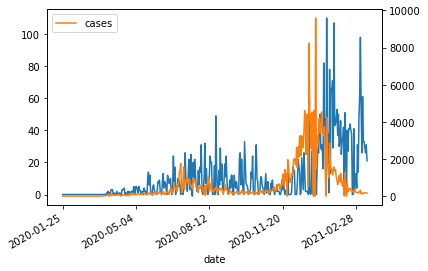

In [81]:
#fips = 6037
#fips = 17031
fips = 4013
fips = 12086
fips = 48201
fips = 6059
group_fips = nyt[nyt["fips"] == fips].set_index("date")
group_fips[ "daily_deaths"].plot( label  = "deaths")
group_fips[ "daily_cases"].plot(secondary_y = True, label = "cases")
plt.legend()
plt.gcf().autofmt_xdate()

<AxesSubplot:>

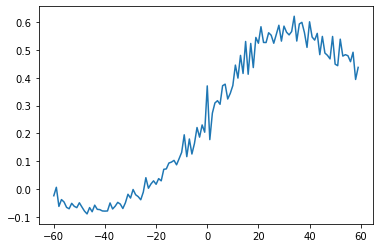

In [82]:
# peak deaths appear approximately 20 days after case detection
intercorrelation(group_fips["daily_deaths"], group_fips["daily_cases"], range ( -60, 60) ).plot()

# Correlation between cases and weather

In [6]:
prcp = pd.read_csv( os.path.join(project_path, "OUT_DATA", "weather_covid_PRCP.csv"))
prcp = prcp.astype( {"fips" : 'Int64', "deaths": 'Int64'})

In [13]:
prcp.tail()

,Unnamed: 0,date,county,state,fips,cases,deaths,state_gazeeter,station_id,v1
884732,3240,2020-12-31,Montgomery,Kentucky,21173,1378,12,Kentucky,USC00155640,157.0
884733,3241,2020-12-31,Meade,Kentucky,21163,1133,4,Kentucky,US1KYMD0002,353.0
884734,3242,2020-12-31,McLean,Kentucky,21149,549,21,NaN,NaN,NaN
884735,3243,2020-12-31,Lewis,Kentucky,21135,775,23,Kentucky,US1KYLW0003,145.0
884736,3244,2020-12-31,Menifee,Kentucky,21165,215,1,Kentucky,USC00152791,122.0


In [14]:
prcp.sort_values([ "state", "fips","county", "date"] , inplace = True)
prcp.index = range(len(prcp))

In [15]:
group_prcp = prcp.groupby(["county", "state", "fips"], dropna = False)

In [17]:
prcp["daily_cases"] = group_prcp["cases"].diff().fillna( prcp["cases"])
prcp["daily_deaths"] = group_prcp["deaths"].diff().fillna( prcp["deaths"])

In [18]:
prcp.head()

,Unnamed: 0,date,county,state,fips,cases,deaths,state_gazeeter,station_id,v1,daily_cases,daily_deaths
0,906,2020-03-24,Autauga,Alabama,1001,1,0,Alabama,USC00010823,0.0,1.0,0
1,1025,2020-03-25,Autauga,Alabama,1001,4,0,Alabama,USC00010823,0.0,3.0,0
2,1109,2020-03-26,Autauga,Alabama,1001,6,0,Alabama,USC00010823,0.0,2.0,0
3,1190,2020-03-27,Autauga,Alabama,1001,6,0,Alabama,USC00010823,0.0,0.0,0
4,1260,2020-03-28,Autauga,Alabama,1001,6,0,Alabama,USC00010823,0.0,0.0,0


In [19]:
model_pcp = ols("daily_cases ~ v1", data = prcp)
res_pcp = model_pcp.fit()

In [20]:
res_pcp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            daily_cases   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     35.31
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           2.81e-09
Time:                        10:44:23   Log-Likelihood:            -5.5283e+06
No. Observations:              875641   AIC:                         1.106e+07
Df Residuals:                  875639   BIC:                         1.106e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.8113      0.150    152.144      0.000      22.517      23.105
v1            -0.0090      0.002     -5.942      0.000      -0.012      -0.006
==============================================================================
Omnibus:                  2508770.152   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     400416560870.125
Skew:                          38.354   Prob(JB):                         0.00
Kurtosis:                    3314.938   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
prcp["daily_cases"].corr( prcp["v1"])

-0.006350167099650646

In [23]:
tmin = pd.read_csv( os.path.join(project_path, "OUT_DATA", "weather_covid_TMIN.csv"))
tmin = tmin.astype( {"fips" : 'Int64', "deaths": 'Int64'})

tmin.sort_values([ "state", "fips","county", "date"] , inplace = True)
tmin.index = range(len(tmin))

group_tmin = tmin.groupby(["county", "state", "fips"], dropna = False)

tmin["daily_cases"] = group_tmin["cases"].diff().fillna( tmin["cases"])
tmin["daily_deaths"] = group_tmin["deaths"].diff().fillna( tmin["deaths"])

In [24]:
model_tmin = ols("daily_cases ~ v1", data = tmin)
res_tmin = model_tmin.fit()

res_tmin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            daily_cases   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1257.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          4.38e-275
Time:                        10:53:12   Log-Likelihood:            -5.5792e+06
No. Observations:              876720   AIC:                         1.116e+07
Df Residuals:                  876718   BIC:                         1.116e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.3213      0.219    129.250      0.000      27.892      28.751
v1            -0.0562      0.002    -35.451      0.000      -0.059      -0.053
==============================================================================
Omnibus:                  2719382.190   Durbin-Watson:                   0.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1005510044322.649
Skew:                          47.623   Prob(JB):                         0.00
Kurtosis:                    5248.620   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""